# Table of Contents
 <p><div class="lev1 toc-item"><a href="#reading-and-preparing-data" data-toc-modified-id="reading-and-preparing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>reading and preparing data</a></div><div class="lev1 toc-item"><a href="#Trajector-Clustering-on-Dimension-reduction" data-toc-modified-id="Trajector-Clustering-on-Dimension-reduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Trajector Clustering on Dimension reduction</a></div><div class="lev2 toc-item"><a href="#using-4-clusters-on-PC1." data-toc-modified-id="using-4-clusters-on-PC1.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>using 4 clusters on PC1.</a></div><div class="lev1 toc-item"><a href="#Trajectory-Clustering-by-Weight" data-toc-modified-id="Trajectory-Clustering-by-Weight-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trajectory Clustering by Weight</a></div>

# reading and preparing data

In [67]:
#library(ggbiplot)
library(tidyverse, quiet=T)
library(traj)
library(caret, quiet=T)

In [68]:


dat0 <- read.csv("../training_ultrasound.csv")

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID)
        )
dat.raw %>% glimpse
# clean data, remove samples with only one observation and after-birth
dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1) %>%
    filter(AGEDAYS<0)


dat.train.raw = dat %>% ungroup %>%
    select(GAGEDAYS, SUBJID, ABCIRCM, HCIRCM, BPDCM, FEMURCM, WTKG.estimate) %>%
    filter(complete.cases(.)) %>% group_by(SUBJID) %>%
    mutate(measurementId = row_number(), tot_measurements=n()) %>%
    filter(measurementId < 7) %>%
    filter(tot_measurements >1) %>% 
    ungroup
#     filter(GAGEDAYS > 150, GAGEDAYS <210)

dat.train = dat.train.raw %>% dplyr::select(-WTKG.estimate)

dat.train.raw %>% head

Observations: 17,370
Variables: 37
$ STUDYID       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SUBJID        <int> 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003,...
$ SEXN          <int> 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SEX           <fctr> Female, Female, Female, Male, Male, Male, Male, Male...
$ GAGEBRTH      <int> 276, 276, 276, 280, 280, 280, 280, 280, 280, 280, 280...
$ BIRTHWT       <int> 3540, 3540, 3540, 3100, 3100, 3100, 3100, 3100, 3100,...
$ BIRTHLEN      <dbl> 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3,...
$ BIRTHHC       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...
$ DELIVERY      <fctr> Category 2.0, Category 2.0, Category 2.0, Category 2...
$ PARITY        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GRAVIDA       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GAGEDAYS      <int> 255, 277, 669, 223, 224, 263, 266, 281, 321, 463, 645...
$ AGEDAYS       <

GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,WTKG.estimate,measurementId,tot_measurements
223,1003,25.6,29.2,8.2,6.3,1.7124993,1,4
224,1003,25.6,29.2,8.2,6.3,1.7124993,2,4
263,1003,30.2,31.0,9.1,7.2,2.6278574,3,4
266,1003,30.2,31.0,9.1,7.2,2.6278574,4,4
169,1005,18.7,21.9,5.9,4.1,0.5989562,1,3
222,1005,25.7,27.9,7.9,5.5,1.4557182,2,3


# Trajector Clustering on Dimension reduction

We use PCA to reduce the four physical variables to one single dimension

In [69]:
dat.train %>% head

dat.prcomp = dat.train  %>%
    select(-GAGEDAYS, -SUBJID) %>% 
    filter(complete.cases(.)) %>% 
    mutate_each(funs(as.numeric(.))) %>%
    prcomp(., center=T, scale.=T)

dat.prcomp$x %>% head

dat.train %>% nrow

GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,measurementId,tot_measurements
223,1003,25.6,29.2,8.2,6.3,1,4
224,1003,25.6,29.2,8.2,6.3,2,4
263,1003,30.2,31.0,9.1,7.2,3,4
266,1003,30.2,31.0,9.1,7.2,4,4
169,1005,18.7,21.9,5.9,4.1,1,3
222,1005,25.7,27.9,7.9,5.5,2,3


PC1,PC2,PC3,PC4,PC5,PC6
-0.4715764,0.67957094,-1.12691188,-0.19629625,-0.17173840,0.063312976
-0.7233287,0.26305438,-0.50544025,-0.20224797,-0.18265863,0.035441636
-1.8748892,0.03143977,-0.11459382,-0.01366700,-0.19869083,0.190016840
-2.1266415,-0.38507680,0.50687781,-0.01961872,-0.20961106,0.162145501
1.6982165,0.78400371,-0.17879392,-0.06681389,0.06144267,-0.074348881
-0.3198239,0.73161175,-0.02267587,-0.13408528,0.15917929,0.004606761


[1] 7547

In [70]:
PC1 = dat.prcomp$x %>% tbl_df %>% select(PC1) 

dat.train$PC1 = -1 * PC1$PC1
dat.train %>% head



GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,measurementId,tot_measurements,PC1
223,1003,25.6,29.2,8.2,6.3,1,4,0.4715764
224,1003,25.6,29.2,8.2,6.3,2,4,0.7233287
263,1003,30.2,31.0,9.1,7.2,3,4,1.8748892
266,1003,30.2,31.0,9.1,7.2,4,4,2.1266415
169,1005,18.7,21.9,5.9,4.1,1,3,-1.6982165
222,1005,25.7,27.9,7.9,5.5,2,3,0.3198239


In [71]:
dat.times = dat.train %>% 
    select(SUBJID, measurementId, GAGEDAYS) %>% 
    spread(measurementId, GAGEDAYS) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
dat.values = dat.train %>% 
    select(SUBJID, measurementId, PC1) %>%  
    spread(measurementId, PC1) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

In [72]:
dat.times %>% head
dat.values %>% head


,SUBJID,1,2,3,4,5,6
1,1003,223,224,263,266,NA,NA
2,1005,169,222,264,NA,NA,NA
3,1006,222,266,NA,NA,NA,NA
4,1009,168,231,NA,NA,NA,NA
5,1011,168,219,261,NA,NA,NA
6,1012,168,169,231,232,259,260


,SUBJID,1,2,3,4,5,6
1,1003,0.4715764,0.72332867,1.874889,2.126641,NA,NA
2,1005,-1.6982165,0.31982386,1.677806,NA,NA,NA
3,1006,0.4568468,1.65475082,NA,NA,NA,NA
4,1009,-2.0430656,0.63651228,NA,NA,NA,NA
5,1011,-1.9076118,0.03037581,1.418334,NA,NA,NA
6,1012,-1.7344576,-1.48270541,1.256527,1.508279,2.707944,2.959696


In [73]:
library(traj)

In [74]:
s1 = step1measures(dat.values, dat.times, ID=T)

[1] "Correlation of m1 and m5 : 1"
[1] "Correlation of m11 and m15 : 1"


In [75]:
s2 = step2factors(s1)

[1] "m5 is removed because it is perfectly correlated with m1"  
[2] "m15 is removed because it is perfectly correlated with m11"
[1] "Computing reduced correlation e-values..."


In [76]:
s3 = step3clusters(s2,4 )

In [77]:
s3$clusters %>% count(cluster)


cluster,n
1,923
2,1
3,1
4,6


## using 4 clusters on PC1. 

Cluster 4 has a drop between days 150-200

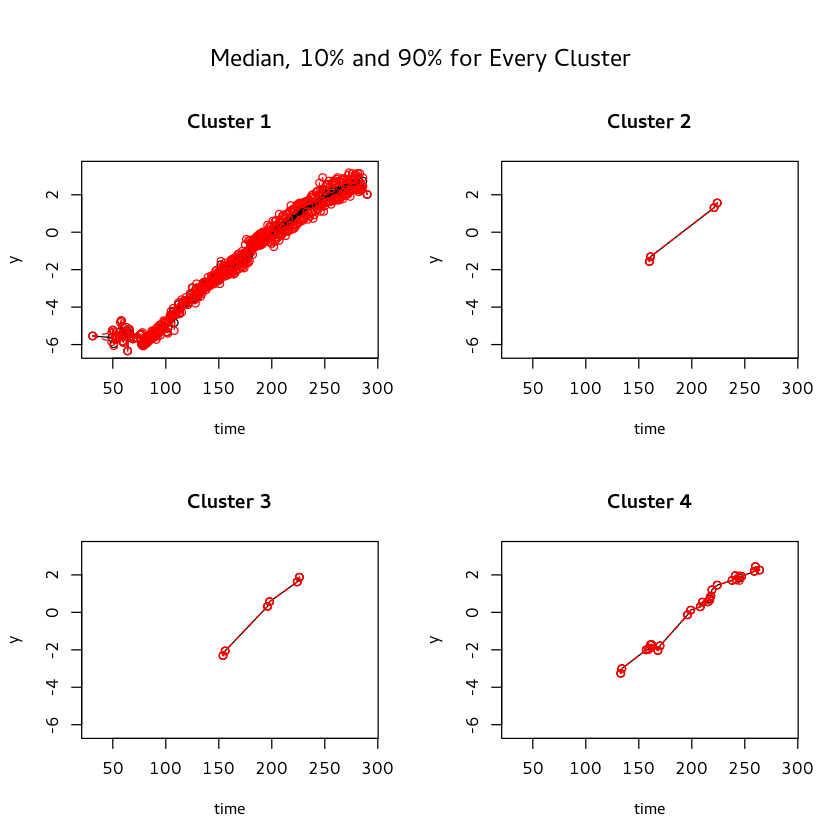

In [78]:
plotMedTraj(s3)

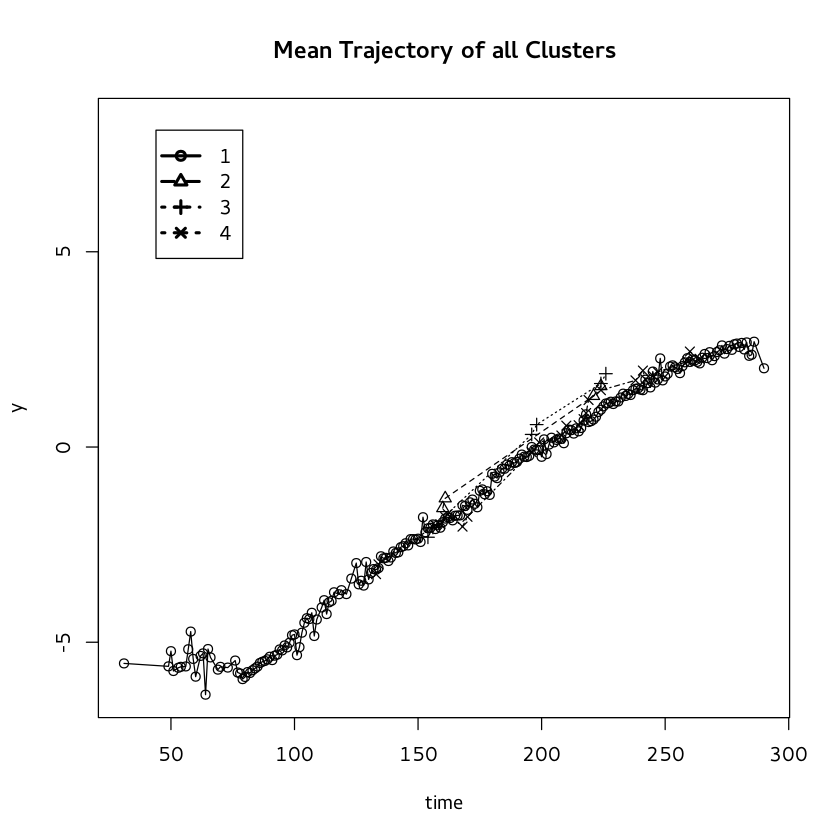

In [79]:
plotCombTraj(s3)

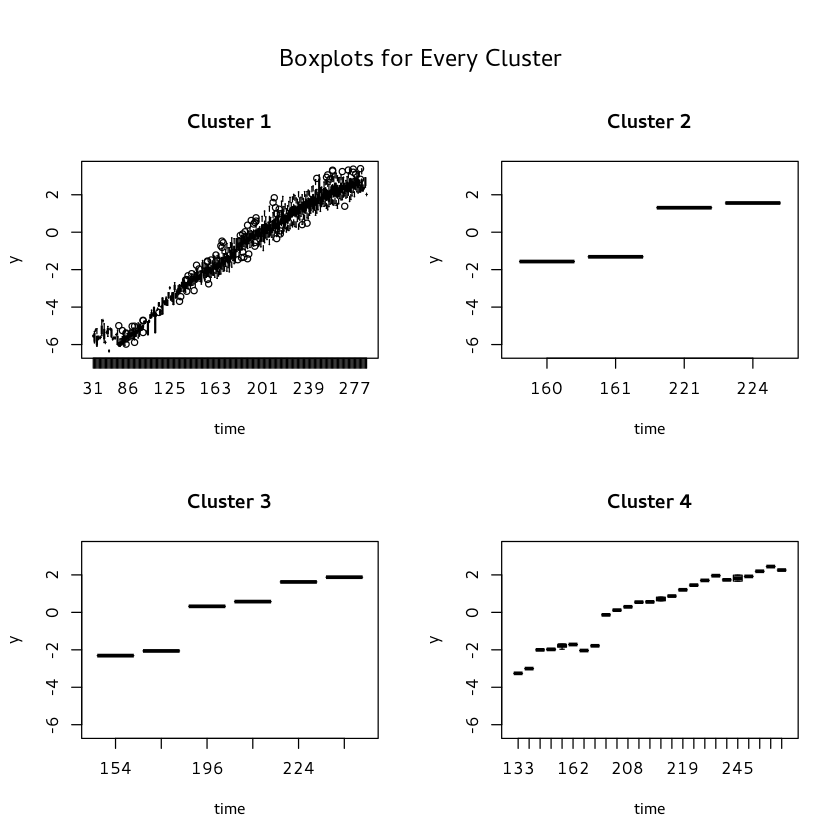

In [80]:
plotBoxplotTraj(s3)

# Trajectory Clustering by Weight


In [81]:
dat.train.raw %>% head


GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,WTKG.estimate,measurementId,tot_measurements
223,1003,25.6,29.2,8.2,6.3,1.7124993,1,4
224,1003,25.6,29.2,8.2,6.3,1.7124993,2,4
263,1003,30.2,31.0,9.1,7.2,2.6278574,3,4
266,1003,30.2,31.0,9.1,7.2,2.6278574,4,4
169,1005,18.7,21.9,5.9,4.1,0.5989562,1,3
222,1005,25.7,27.9,7.9,5.5,1.4557182,2,3


In [83]:
dat.times = dat.train.raw %>% 
    select(SUBJID, measurementId, GAGEDAYS) %>% 
    spread(measurementId, GAGEDAYS) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
dat.values = dat.train.raw %>% 
    select(SUBJID, measurementId, WTKG.estimate) %>%  
    spread(measurementId, WTKG.estimate) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

dat.times %>% head
dat.values %>% head

,SUBJID,1,2,3,4,5,6
1,1003,223,224,263,266,NA,NA
2,1005,169,222,264,NA,NA,NA
3,1006,222,266,NA,NA,NA,NA
4,1009,168,231,NA,NA,NA,NA
5,1011,168,219,261,NA,NA,NA
6,1012,168,169,231,232,259,260


,SUBJID,1,2,3,4,5,6
1,1003,1.7124993,1.7124993,2.627857,2.627857,NA,NA
2,1005,0.5989562,1.4557182,2.460492,NA,NA,NA
3,1006,1.7424318,2.6286793,NA,NA,NA,NA
4,1009,0.5061012,1.7751113,NA,NA,NA,NA
5,1011,0.5823398,1.2789009,2.225963,NA,NA,NA
6,1012,0.6115616,0.6115616,1.987976,1.987976,3.034302,3.034302


In [84]:
s1 = step1measures(dat.values, dat.times, ID=T)

[1] "Correlation of m1 and m5 : 0.999"
[1] "Correlation of m11 and m15 : 1"


In [85]:
s2 = step2factors(s1)

[1] "m5 is removed because it is perfectly correlated with m1"  
[2] "m15 is removed because it is perfectly correlated with m11"
[1] "Computing reduced correlation e-values..."


cluster,n
1,16
2,135
3,51
4,87
5,56
6,75
7,48
8,42
9,141
10,106


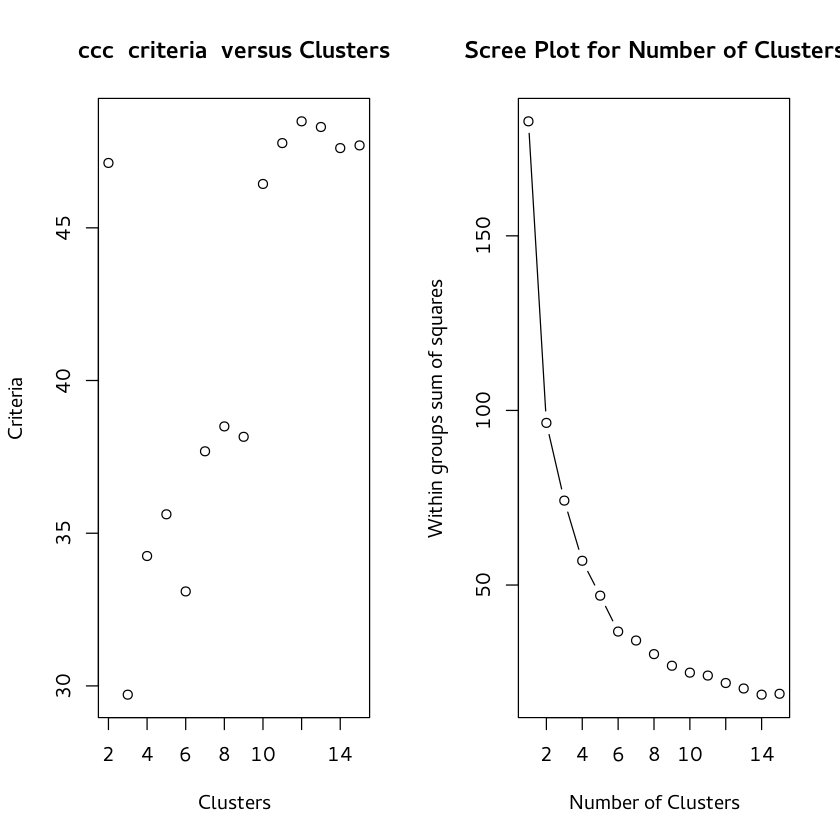

In [87]:
s3 = step3clusters(s2)
s3$clusters %>% count(cluster)

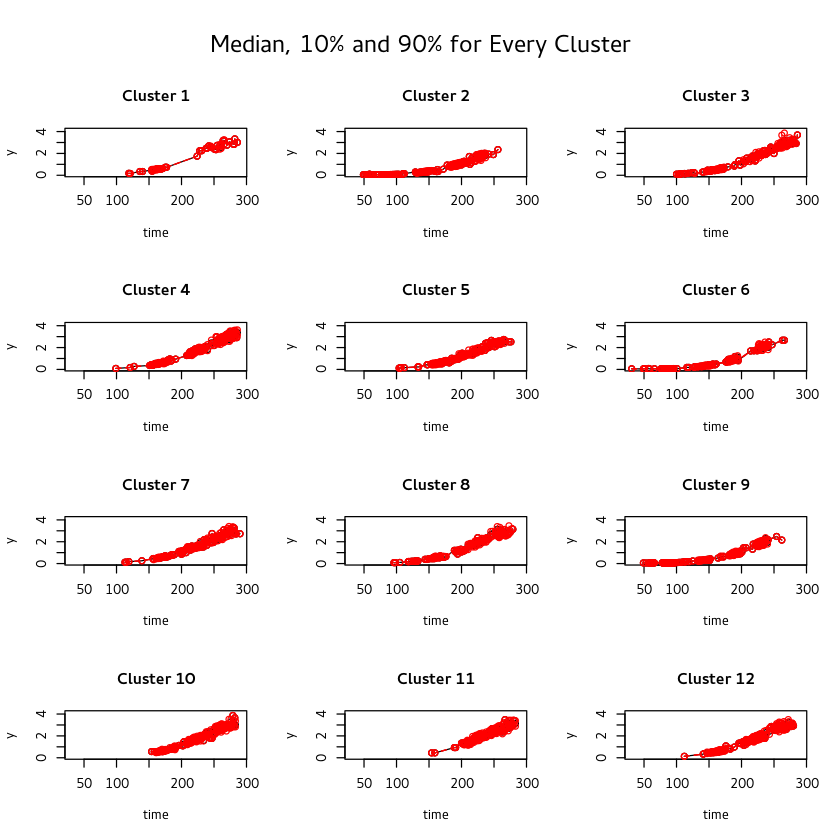

In [88]:
plotMedTraj(s3)

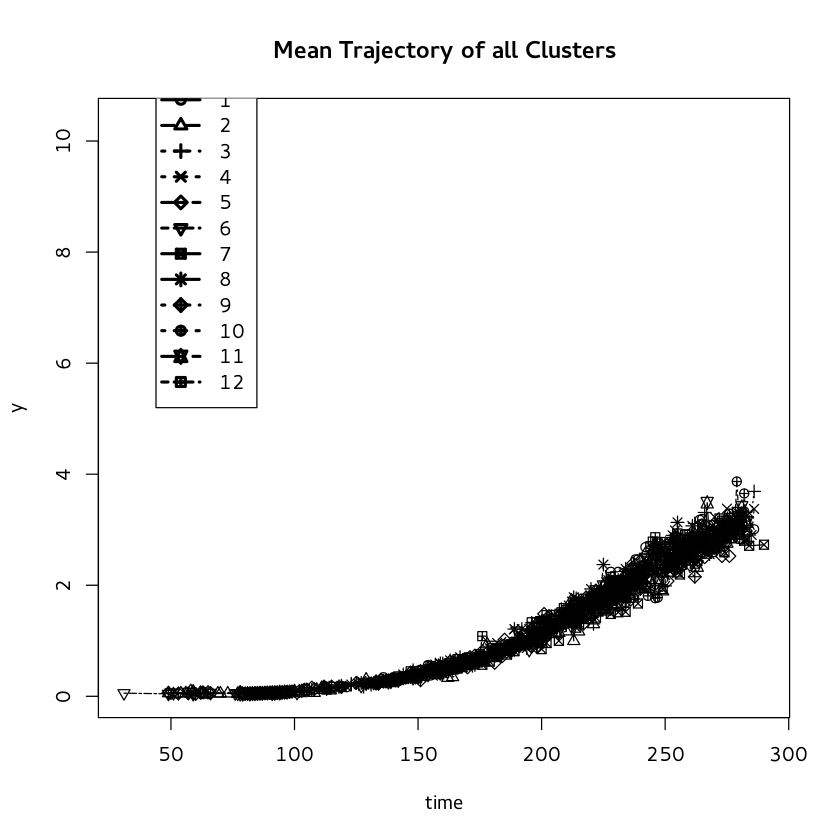

In [89]:
plotCombTraj(s3)

cluster,n
1,417
2,514


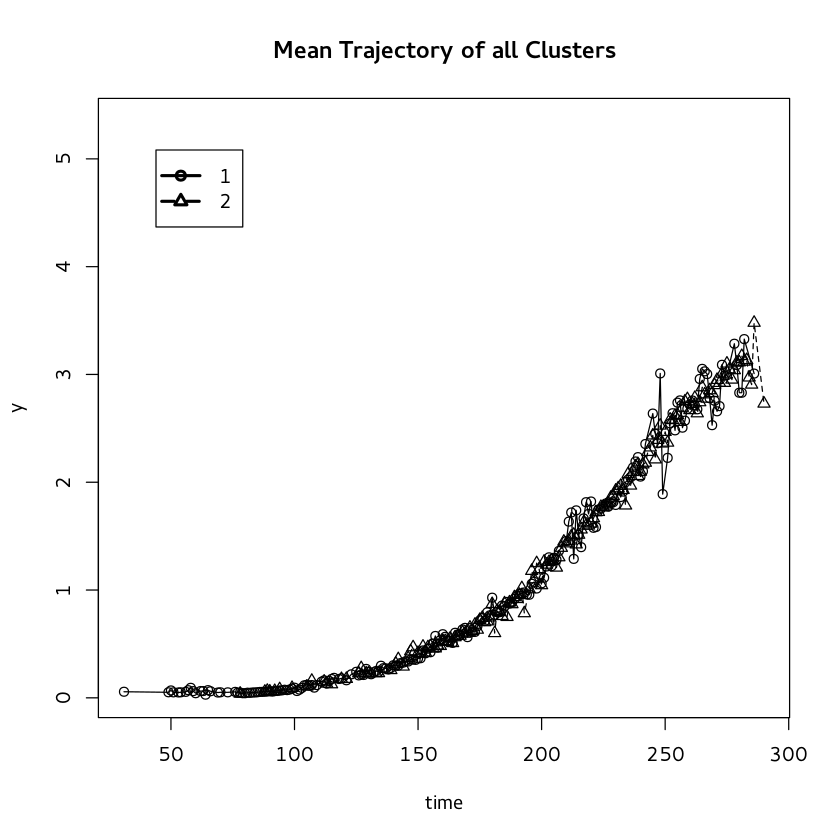

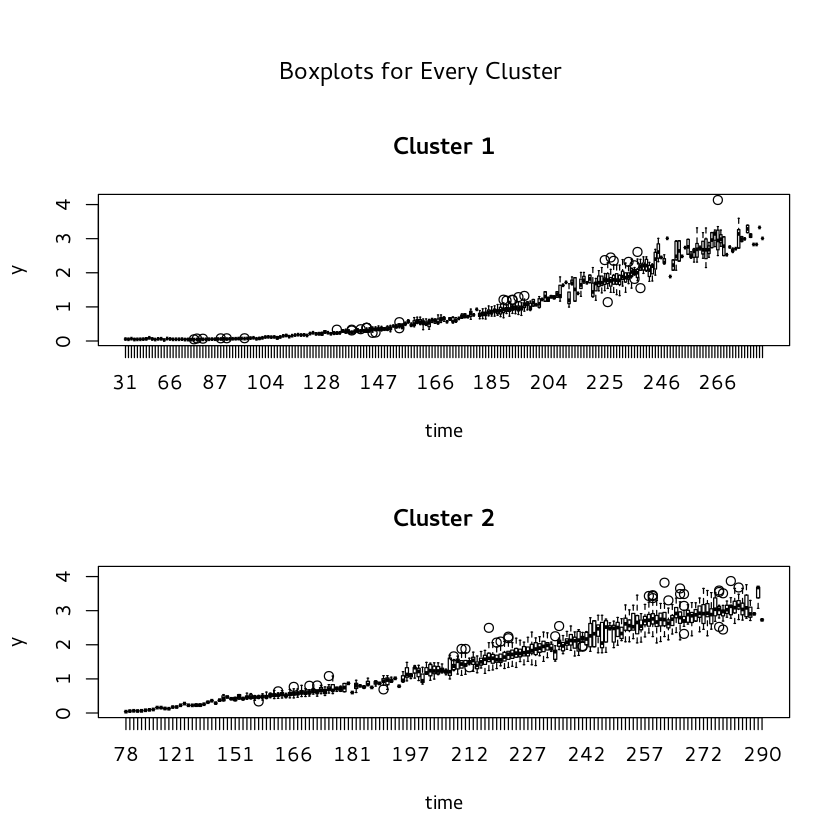

In [98]:
s3.2c = step3clusters(s2, 2)
s3.2c$clusters %>% count(cluster)
plotCombTraj(s3.2c)
plotBoxplotTraj(s3.2c)